In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def ClassPrintMetrics(y_real, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_real, y_pred)

    y_real_labels = list(map(str,sorted(y_real.unique().tolist())))

    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_real_labels)

    disp.plot()

    print(metrics.classification_report(y_real, y_pred))


dataset = pd.read_csv(r"..\data\processed\feature_all.txt", delimiter=" ")


In [2]:
def get_imbalanced_test_split(X, y, test_phish_count=50, ratio=1000, seed=42):
    """
    Creates a custom train/test split with a fixed ratio of 1000:1 (Legit:Phish) in the test set.
    
    Args:
        X: Features (Dataframe, Series, or List)
        y: Labels (Dataframe, Series, or List/Array)
        test_phish_count: How many phishing URLs to put in the Test Set.
        ratio: How many legitimate URLs per phishing URL (default 1000).
        seed: Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Ensure inputs are standard format (Pandas Series or Numpy Array) for indexing
    if isinstance(X, list): X = np.array(X)
    if isinstance(y, list): y = np.array(y)
    
    # If X/y are DataFrames, extract the underlying array/series
    if isinstance(y, pd.DataFrame): y = y.iloc[:, 0]
    
    # Identify indices
    # We assume Label 1 = Phishing, Label 0 = Legitimate
    phish_indices = np.where(y == 1)[0]
    legit_indices = np.where(y == 0)[0]
    
    # Calculate Test Sizes
    n_test_phish = test_phish_count
    n_test_legit = test_phish_count * ratio
    
    # Checks
    if len(phish_indices) < n_test_phish:
        raise ValueError(f"Not enough Phishing samples. Have {len(phish_indices)}, need {n_test_phish}")
    if len(legit_indices) < n_test_legit:
        raise ValueError(f"Not enough Legitimate samples. Have {len(legit_indices)}, need {n_test_legit}")
        
    print(f"Creating 1000:1 Test Split...")
    print(f"Test Set: {n_test_phish} Phishing, {n_test_legit} Legitimate (Total: {n_test_phish + n_test_legit})")
    
    # Shuffle indices
    np.random.shuffle(phish_indices)
    np.random.shuffle(legit_indices)
    
    # Select Indices for Test
    test_idx_phish = phish_indices[:n_test_phish]
    test_idx_legit = legit_indices[:n_test_legit]
    test_indices = np.concatenate([test_idx_phish, test_idx_legit])
    np.random.shuffle(test_indices) # Shuffle the test set itself
    
    # Select Indices for Train (The Rest)
    train_idx_phish = phish_indices[n_test_phish:]
    train_idx_legit = legit_indices[n_test_legit:]
    train_indices = np.concatenate([train_idx_phish, train_idx_legit])
    np.random.shuffle(train_indices) # Shuffle the train set
    
    # Perform Split
    # Handle pandas vs numpy indexing
    if isinstance(X, (pd.DataFrame, pd.Series)):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    else:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
    return X_train, X_test, y_train, y_test

Phishing?
0    426156
1     81015
Name: count, dtype: int64

<Axes: >

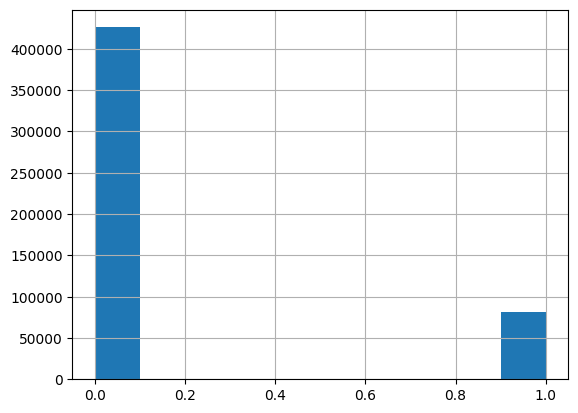

In [3]:
display(dataset["Phishing?"].value_counts())
# quality_num_bins = np.sort(dataset["Phishing?"].unique()) # Num bins = Num of unique target values
dataset["Phishing?"].hist()

In [4]:
# --- REPLACEMENT START ---
X = dataset.drop(columns="Phishing?", inplace=False)
y = dataset["Phishing?"]

# Use 50 Phishing samples for test, resulting in 50,000 Legitimate samples (1000:1)
url_train_x, url_test_x, url_train_y, url_test_y = get_imbalanced_test_split(X, y, test_phish_count=50, ratio=1000)

# XGBoost uses an eval set (validation). 
# Since we now have a specific test set, we should split the TRAIN set again if you want a validation set for early stopping,
# OR just use the test set (though using test for validation is technically leakage, but standard in simple benchmarks).
url_val_x = url_test_x
url_val_y = url_test_y

Creating 1000:1 Test Split...
Test Set: 50 Phishing, 50000 Legitimate (Total: 50050)


In [5]:
url_train_x = url_train.drop(columns="Phishing?", inplace=False)
url_train_y = url_train["Phishing?"]

url_val_x = url_val.drop(columns="Phishing?", inplace=False)
url_val_y = url_val["Phishing?"]

url_test_x = url_test.drop(columns="Phishing?", inplace=False)
url_test_y = url_test["Phishing?"]

NameError: name 'url_train' is not defined

In [6]:
from benchmark import PerformanceMonitor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# Wichtig: Das Modul metrics muss verfügbar sein
from sklearn import metrics as sklearn_metrics 
from xgboost import XGBClassifier
import numpy as np

# 1. Monitor initialisieren
monitor = PerformanceMonitor("XGBoost")

# --- TRAINING ---
print("Starte Training...")
monitor.start_measurement()

# --- VORBEREITUNG ---
# Daten vorher umwandeln, um Kopieren während des Trainings zu vermeiden
X_train = url_train_x.astype('float32')
y_train = url_train_y.astype('float32')
X_val = url_val_x.astype('float32')
y_val = url_val_y.astype('float32')


bst = XGBClassifier(
    n_estimators=5000,
    max_depth=6,
    learning_rate=0.01,
    objective='binary:logistic',
    early_stopping_rounds=50,
    tree_method="hist",  # Effizientester Algorithmus für GPU
    device="cuda"        # Aktiviert die GPU
)

# Training durchführen
# Wir nutzen .astype(float), um Warnungen bei booleschen/object Spalten zu vermeiden
bst.fit(
    url_train_x.astype(float), 
    url_train_y.astype(float),
    eval_set=[(url_val_x.astype(float), url_val_y.astype(float))], 
    verbose=False
)

monitor.end_measurement(task_name="Training")


f:\GitHub Repositorys\Evaluation_of_AI_Models\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Starte Training...
--- Ergebnisse XGBoost (Training) ---
Zeit: 62.2394s | GPU-Last: 79.3%
VRAM (System): 1629.5 MB | VRAM (Torch): 0.0 MB


{'model': 'XGBoost',
 'task': 'Training',
 'time_sec': 62.2394,
 'ram_mb': 3507.21,
 'vram_mb': 1629.5,
 'torch_vram_mb': 0.0,
 'cpu_percent': 114.8,
 'gpu_util_percent': 79.3}

Starte Inferenz (gesamtes Testset)...


f:\GitHub Repositorys\Evaluation_of_AI_Models\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [10:25:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


--- Ergebnisse XGBoost (Inferenz) ---
Zeit: 1.6105s | GPU-Last: 66.6%
VRAM (System): 1596.94 MB | VRAM (Torch): 0.0 MB

--- Detail-Report (Scikit-Learn) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       0.29      0.98      0.45        50

    accuracy                           1.00     50050
   macro avg       0.65      0.99      0.73     50050
weighted avg       1.00      1.00      1.00     50050



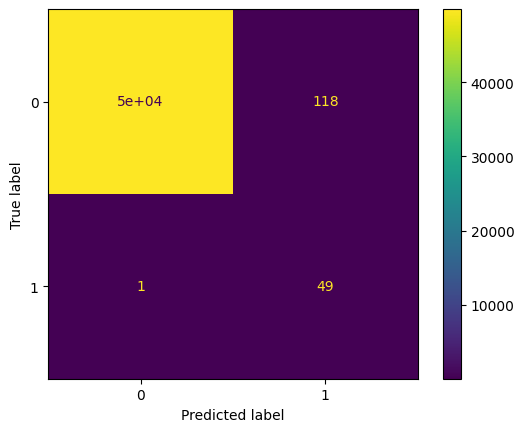

In [7]:
# --- INFERENZ ---
print("Starte Inferenz (gesamtes Testset)...")
monitor.start_measurement()

X_test_ready = url_test_x.astype(float)
y_scores = bst.predict_proba(X_test_ready)[:, 1]
y_pred = bst.predict(X_test_ready)

# --- METRIKEN BERECHNEN ---
y_true = url_test_y.astype(float).values

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_scores)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

# KORREKTUR: Dictionary umbenannt, damit 'metrics' Modul nicht überschrieben wird
metrics_dict = {
    "accuracy": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1_score": round(f1, 4),
    "auc": round(auc, 4),
    "fpr": round(fpr, 4)
}

monitor.end_measurement(task_name="Inferenz", extra_metrics=metrics_dict)

print("\n--- Detail-Report (Scikit-Learn) ---")
# Da wir 'metrics' nicht überschrieben haben, funktioniert dieser Aufruf jetzt wieder:
ClassPrintMetrics(url_test_y, y_pred)